In [11]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
import numpy as np
import pandas as pd
import os
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from fixpoint_utils import (
    keypoints_IoU_mult,
    get_acc,
    get_acc_EfficentNet, 
    save_checkpoint, 
    load_checkpoint, 
    get_loader_keypoint,
    plot_keypoints_IoU)

from torchvision.ops import (
    masks_to_boxes,
    generalized_box_iou
)
import matplotlib.patches as patches

from Keypoint_dataset import Keypoint_dataset
from torch.optim.lr_scheduler import StepLR
from models_2 import ResNet, BasicBlock, KeypointModel, KeypointCNN, EfficentNet, EfficentNet_3, UNET, KeypointModel_with_segm

In [12]:
# HYPERPARAMETERS:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LOGGING = False
NUM_EPOCHS = 100
random.seed(42)
torch.manual_seed(42)
loss_func = nn.MSELoss()

In [21]:
df_path = r'/home/alex/Documents/new try/Data/Studie_daten/Study_data.csv'
df = pd.read_csv(df_path, sep = ';')
df.__len__()

486

Image with first keypoints

[(1306.066, 224.175), (1189.105, 2002.959), (2154.034, 2183.274), (214.429, 1924.985), (1047.777, 297.276), (1547.298, 282.656)]


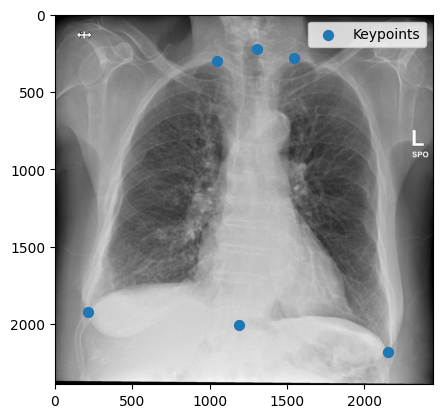

In [14]:
idx = 5
img_path = df['new path'][idx]
img = np.array(Image.open(img_path).convert('L'))
keypoints = [(df['X_Th1_Original'][idx], df['Y_Th1_Original'][idx]),
                (df['X_Th12_Original'][idx], df['Y_Th12_Original'][idx]),
                (df['X_LeftRecess_Original'][idx], df['Y_LeftRecess_Original'][idx]),
                (df['X_RightRecess_Original'][idx], df['Y_RightRecess_Original'][idx]),
                (df['X_UpperLung_Right'][idx], df['Y_UpperLung_Right'][idx]),
                (df['X_UpperLung_Left'][idx], df['Y_UpperLung_Left'][idx])] 
                #T1_original, T12_original, LeftRecess_original, RightRecess_original
print(keypoints)

plt.imshow(img, cmap ='gray', vmin=0, vmax=255)
for i in range(6):
        if i == 0:
                plt.scatter(keypoints[i][0],keypoints[i][1], color = 'C0', s = 50, label = 'Keypoints')
        else:
                plt.scatter(keypoints[i][0],keypoints[i][1], color = 'C0', s = 50)
plt.legend()     
plt.show()

Rotated


[(1608.638, 579.251), (1608.728, 2361.876), (2583.415, 2478.442), (631.036, 2348.069)]


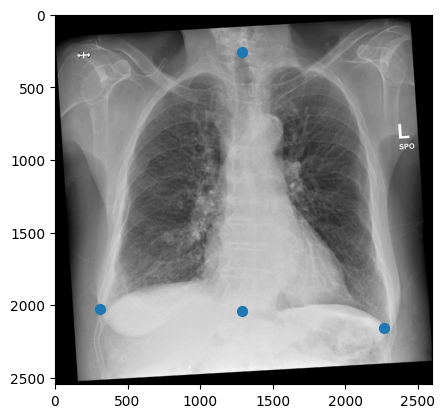

In [15]:
from scipy.ndimage import rotate
from skimage.transform import resize
img_path = df['new path'][idx]
img = np.array(Image.open(img_path).convert('L'))
keypoints = [(df['X_Th1_Rotated'][idx], df['Y_Th1_Rotated'][idx]),
                (df['X_Th12_Rotated'][idx], df['Y_Th12_Rotated'][idx]),
                (df['X_LeftRecess_Rotated'][idx], df['Y_LeftRecess_Rotated'][idx]),
                (df['X_RightRecess_Rotated'][idx], df['Y_RightRecess_Rotated'][idx])] 
                #T1_original, T12_original, LeftRecess_original, RightRecess_original
print(keypoints)
angle = -df['ROTATION_DEGREES'][idx]
img_rotate = rotate(img, angle)
factor = 1
plt.imshow(img_rotate, cmap ='gray', vmin=0, vmax=255)
for i in range(4):
        plt.scatter(keypoints[i][0]-320,keypoints[i][1]-320, color = 'C0', s = 50)
            
plt.show()

Upper lung

[(1047.777, 297.276), (1547.298, 282.656)]


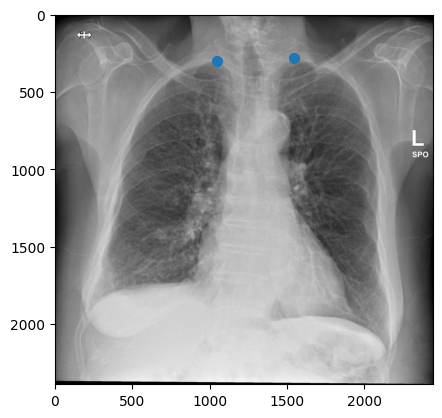

In [16]:

img_path = df['new path'][idx]
img = np.array(Image.open(img_path).convert('L'))
keypoints = [(df['X_UpperLung_Right'][idx], df['Y_UpperLung_Right'][idx]),
                (df['X_UpperLung_Left'][idx], df['Y_UpperLung_Left'][idx])]
                #T1_original, T12_original, LeftRecess_original, RightRecess_original
print(keypoints)

plt.imshow(img, cmap ='gray', vmin=0, vmax=255)
for i in range(2):
        plt.scatter(keypoints[i][0],keypoints[i][1], color = 'C0', s = 50)
            
plt.show()

Acutal exposed area

[(2729, 300), (2884, 2665), (447, 2806), (291, 441)]


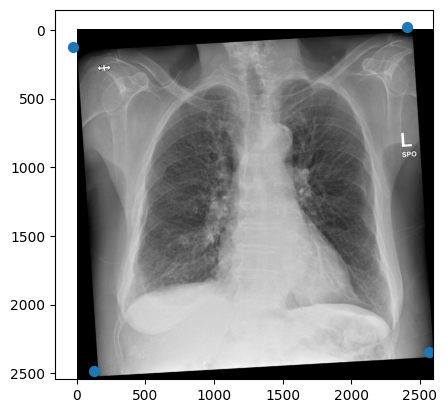

In [17]:

img_path = df['new path'][idx]
img = np.array(Image.open(img_path).convert('L'))
keypoints = [(df['X1'][idx], df['Y1'][idx]),
                (df['X2'][idx], df['Y2'][idx]),
                (df['X3'][idx], df['Y3'][idx]),
                (df['X4'][idx], df['Y4'][idx])] 
                #T1_original, T12_original, LeftRecess_original, RightRecess_original
print(keypoints)

angle = -df['ROTATION_DEGREES'][idx]
plt.imshow(rotate(img, angle), cmap ='gray', vmin=0, vmax=255)
for i in range(4):
        plt.scatter(keypoints[i][0]-320,keypoints[i][1]-320, color = 'C0', s = 50)
            
plt.show()

MinFS

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

def draw_rectangle(image, points, color='r', thickness=2):
    """
    Draw a rectangle on an image using 4 corner points and matplotlib.

    :param image: Input image (numpy array)
    :param points: List of 4 corner points (each as (x, y) tuples)
    :param color: Color of the rectangle (default is red)
    :param thickness: Thickness of the rectangle lines (default is 2)
    :return: None (displays the image)
    """
    # Convert the image to RGB if it is in BGR format (as loaded by OpenCV)
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Create the polygon using the 4 corner points
    polygon = Polygon(points, closed=True, edgecolor=color, fill=False, linewidth=thickness)

    # Add the polygon (rectangle) to the axis
    ax.add_patch(polygon)

    # Show the plot with the rectangle
    plt.show()

In [25]:
img_path = df['new path'][idx]
img = np.array(Image.open(img_path).convert('L'))
keypoints = [(df['X5'][idx]-320, df['Y5'][idx]-320),
                (df['X6'][idx]-320, df['Y6'][idx]-320),
                (df['X7'][idx]-320, df['Y7'][idx]-320),
                (df['X8'][idx]-320, df['Y8'][idx]-320)]
print(keypoints)


keypoints = [(df['X9'][idx]-320, df['Y9'][idx]-320),
                (df['X10'][idx]-320, df['Y10'][idx]-320),
                (df['X11'][idx]-320, df['Y11'][idx]-320),
                (df['X12'][idx]-320, df['Y12'][idx]-320)] 

print(keypoints)

[(2605, 322), (2605, 1906), (344, 1906), (344, 322)]
[(2740.135, 186.865), (2740.135, 2041.1350000000002), (208.865, 2041.1350000000002), (208.865, 186.865)]


In [ ]:

img_path = df['new path'][idx]
img = np.array(Image.open(img_path).convert('L'))
keypoints = [(df['X5'][idx]-320, df['Y5'][idx]-320),
                (df['X6'][idx]-320, df['Y6'][idx]-320),
                (df['X7'][idx]-320, df['Y7'][idx]-320),
                (df['X8'][idx]-320, df['Y8'][idx]-320)]
                #T1_original, T12_original, LeftRecess_original, RightRecess_original
print(keypoints)

angle = -df['ROTATION_DEGREES'][idx]

fig, ax = plt.subplots()
ax.imshow(rotate(img, angle), cmap ='gray', vmin=0, vmax=255)
for i in range(4):
       plt.scatter(keypoints[i][0],keypoints[i][1], color = 'C0', s = 50)

polygon = Polygon(keypoints, closed=True, edgecolor= 'C0', fill=False, linewidth=3)

# Add the polygon (rectangle) to the axis
ax.add_patch(polygon)


keypoints = [(df['X9'][idx]-320, df['Y9'][idx]-320),
                (df['X10'][idx]-320, df['Y10'][idx]-320),
                (df['X11'][idx]-320, df['Y11'][idx]-320),
                (df['X12'][idx]-320, df['Y12'][idx]-320)] 
for i in range(4):
       plt.scatter(keypoints[i][0],keypoints[i][1], color = 'C1', s = 50)
polygon = Polygon(keypoints, closed=True, edgecolor= 'C1', fill=False, linewidth=3)

# Add the polygon (rectangle) to the axis
ax.add_patch(polygon)


plt.show()

average tolerances

In [32]:
img_path = df['new path'][idx]
img = np.array(Image.open(img_path).convert('L'))
img.shape[0], img.shape[1]

(2651, 2887)

In [39]:
tolerance_1, tolerance_2, tolerance_3, tolerance_4 = [], [] ,[] ,[]
image_size_x, image_size_y = [], []
for idx in range(486):
    tolerance_1.append(np.abs(df['X5'][idx] - df['X9'][idx]))
    tolerance_2.append(np.abs(df['X6'][idx] - df['X10'][idx]))
    tolerance_3.append(np.abs(df['X7'][idx] - df['X11'][idx]))
    tolerance_4.append(np.abs(df['X8'][idx] - df['X12'][idx]))
    img_path = df['new path'][idx]
    img = np.array(Image.open(img_path).convert('L'))
    image_size_x.append(img.shape[0]) 
    image_size_y.append(img.shape[1])

print((np.mean(image_size_x)/256), np.mean(image_size_y)/256)

[1386.8956674833894, 138.2798930041154, 138.2798930041152, 138.2798930041152]
10.029626414609053 10.888832626028806


In [46]:
print(np.mean(image_size_y), (np.mean(image_size_x)))

2787.5411522633744 2567.5843621399176


In [43]:
factor_x, factor_y = np.mean(image_size_y)/256, (np.mean(image_size_x)/256)
print(factor_x, factor_y )
print(([np.mean(tolerance_1)/factor_x, np.mean(tolerance_2)/factor_x, np.mean(tolerance_3)/factor_x, np.mean(tolerance_4)/factor_x]))
#print((np.mean(image_size_x)/256), np.mean(image_size_y)/256)

10.888832626028806 10.029626414609053
[12.699239464253436, 12.699239464253436, 12.699239464253418, 12.699239464253418]


In [44]:
tolerance_1, tolerance_2, tolerance_3, tolerance_4 = [], [] ,[] ,[]
image_size_x, image_size_y = [], []
for idx in range(486):
    tolerance_1.append(np.abs(df['Y5'][idx] - df['Y9'][idx]))
    tolerance_2.append(np.abs(df['Y6'][idx] - df['Y10'][idx]))
    tolerance_3.append(np.abs(df['Y7'][idx] - df['Y11'][idx]))
    tolerance_4.append(np.abs(df['Y8'][idx] - df['Y12'][idx]))
    img_path = df['new path'][idx]
    img = np.array(Image.open(img_path).convert('L'))
    image_size_x.append(img.shape[0]) 
    image_size_y.append(img.shape[1])

In [45]:
factor_x, factor_y = np.mean(image_size_y)/256, (np.mean(image_size_x)/256)
print(factor_x, factor_y )
print(([np.mean(tolerance_1)/factor_y, np.mean(tolerance_2)/factor_y, np.mean(tolerance_3)/factor_y, np.mean(tolerance_4)/factor_y]))

10.888832626028806 10.029626414609053
[13.787142939112677, 13.787142939112696, 13.787142939112696, 13.787142939112677]


Toleranzfeld

[(3304.135, 545.865), (3304.135, 3075.135), (393.865, 3075.135), (393.865, 545.865)]


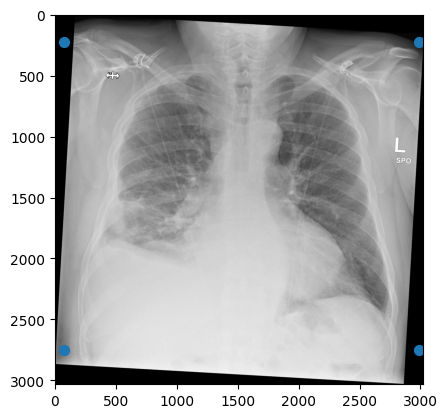

In [10]:

img_path = df['new path'][idx]
img = np.array(Image.open(img_path).convert('L'))
keypoints = [(df['X9'][idx], df['Y9'][idx]),
                (df['X10'][idx], df['Y10'][idx]),
                (df['X11'][idx], df['Y11'][idx]),
                (df['X12'][idx], df['Y12'][idx])] 
                #T1_original, T12_original, LeftRecess_original, RightRecess_original
print(keypoints)

angle = -df['ROTATION_DEGREES'][idx]
plt.imshow(rotate(img, angle), cmap ='gray', vmin=0, vmax=255)
for i in range(4):
       plt.scatter(keypoints[i][0]-320,keypoints[i][1]-320, color = 'C0', s = 50)
            
plt.show()

# Segmentation 

In [13]:
from monai.networks.nets import UNet

EffNet = EfficentNet().to(DEVICE)
Keyp_seg = KeypointModel_with_segm().to(DEVICE)
Own_unet = UNET(in_channels=1, out_channels=1, features= [16, 32, 64, 128]).to(DEVICE)
Monai_UNet = UNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128),
        strides=(2, 2, 2),
        bias = False,
        num_res_units = 0,
    ).to(device=DEVICE)
Keyp = KeypointModel().to(DEVICE)


load_checkpoint(Own_unet, r'/home/alex/Documents/new try/Data/Lung Unet/save_states/Own_Unet_gaussian_10.pth.tar') 
load_checkpoint(Monai_UNet, r'/home/alex/Documents/new try/Data/Lung Unet/save_states/simulate_data/Monai_Unet_poisson0.pth.tar')

#load_checkpoint(Keyp_seg, r'/home/alex/Documents/new try/Data/Studie_daten/safe_states/Keypoint_detection_padding_normalize_segmentation_0.001_1_0_5.pth.tar')
#load_checkpoint(Keyp, r'/home/alex/Documents/new try/Data/Studie_daten/safe_states/Keypoint_detection__0.pth.tar') #r'/home/alex/Documents/new try/Data/Studie_daten/safe_states/Keypoint_detection_padding_0.001_1_0_8.pth.tar')

=> Loading checkpoint
=> Loading checkpoint


In [12]:
def show_image_keypoint_segmentation(image, targ, keypoint_model, segmenation_model):

        img = image.to(device = DEVICE)
        target = targ.to(DEVICE)
        mask = segmenation_model(img)
        pred_mask = (torch.sigmoid(mask) > 0.5)
        concat_tensor = torch.cat((img, img+pred_mask , pred_mask), dim=1)
        pred_keyp = keypoint_model(concat_tensor)


        #images
        fig, axs = plt.subplots(1, 2, figsize=(16, 6))
        axs[0].imshow(image[0,0], cmap ='gray')
        axs[0].imshow(pred_mask[0,0].cpu().detach().numpy(), alpha=0.2, cmap = 'gray') 
        axs[1].imshow(image[0,0], cmap ='gray')


        boxes_EffNet = []
        kp = targ.squeeze(1).detach().numpy().astype(np.uint8)
        pred_kp = pred_keyp.cpu().detach().numpy().astype(np.uint8)
        for keypoints in [kp, pred_kp]:
            keypoint_image = torch.zeros(image[0,0].shape)
            for i in range(0,8,2):
                keypoint_image[keypoints[0,i+1],keypoints[0,i]] = 1        
            boxes_EffNet.append(masks_to_boxes(keypoint_image.unsqueeze(0)))

        test_box, pred_box_EffNet = boxes_EffNet[0][0], boxes_EffNet[1][0]
        for i in range(0,8,2):
            axs[0].scatter(pred_kp[0,i],pred_kp[0,i+1], color = 'C1', s = 50)
            axs[0].scatter(kp[0,i],kp[0,i+1], color = 'C0', s = 50)
        rect_pred = patches.Rectangle((pred_box_EffNet[0], pred_box_EffNet[1]), pred_box_EffNet[2] - pred_box_EffNet[0],
                                    pred_box_EffNet[3] - pred_box_EffNet[1], linewidth=4, edgecolor='C1', facecolor='none', label='predicted crop')
        rect_test = patches.Rectangle((test_box[0], test_box[1]), test_box[2] - test_box[0],
                                    test_box[3] - test_box[1], linewidth=4, edgecolor='C0', facecolor='none', label='true crop')

        #axs[0].add_patch(rect_pred)
        #axs[0].add_patch(rect_test)
        box_iou = generalized_box_iou(boxes_EffNet[0], boxes_EffNet[1])
        box_iou = torch.nan_to_num(box_iou, 0)
        box_iou = torch.trace(box_iou)
        loss = loss_func(pred_keyp, target.squeeze(1))
        
        axs[0].set_title(f'Loss: {loss:.2f}, Box IoU: {box_iou:.2f}')


        boxes_keyp = []
        kp = targ.squeeze(1).detach().numpy().astype(np.uint8)
        pred_kp = pred_keyp.cpu().detach().numpy().astype(np.uint8)
        for keypoints in [kp, pred_kp]:
            keypoint_image = torch.zeros(image[0,0].shape)
            for i in range(0,8,2):
                keypoint_image[keypoints[0,i+1],keypoints[0,i]] = 1        
            boxes_keyp.append(masks_to_boxes(keypoint_image.unsqueeze(0)))

        test_box, pred_box_keyp = boxes_keyp[0][0], boxes_keyp[1][0]
        for i in range(0,8,2):
            axs[1].scatter(pred_kp[0,i],pred_kp[0,i+1], color = 'C1', s = 50)
            axs[1].scatter(kp[0,i],kp[0,i+1], color = 'C0', s = 50)
        rect_pred = patches.Rectangle((pred_box_keyp[0], pred_box_keyp[1]), pred_box_keyp[2] - pred_box_keyp[0],
                                    pred_box_keyp[3] - pred_box_keyp[1], linewidth=4, edgecolor='C1', facecolor='none', label='predicted crop')
        rect_test = patches.Rectangle((test_box[0], test_box[1]), test_box[2] - test_box[0],
                                    test_box[3] - test_box[1], linewidth=4, edgecolor='C0', facecolor='none', label='true crop')

        #axs[1].add_patch(rect_pred)
        #axs[1].add_patch(rect_test)
        box_iou = generalized_box_iou(boxes_keyp[0], boxes_keyp[1])
        box_iou = torch.nan_to_num(box_iou, 0)
        box_iou = torch.trace(box_iou)
        loss = loss_func(pred_keyp, target.squeeze(1))
        #axs[1].set_title(f'Mixed KeypointModel: Loss: {loss:.2f}, Box IoU: {box_iou:.2f}')


        plt.legend()
        plt.tight_layout()
        plt.show()
            

=> Loading checkpoint


/tmp/ipykernel_3070092/2561914169.py:73: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


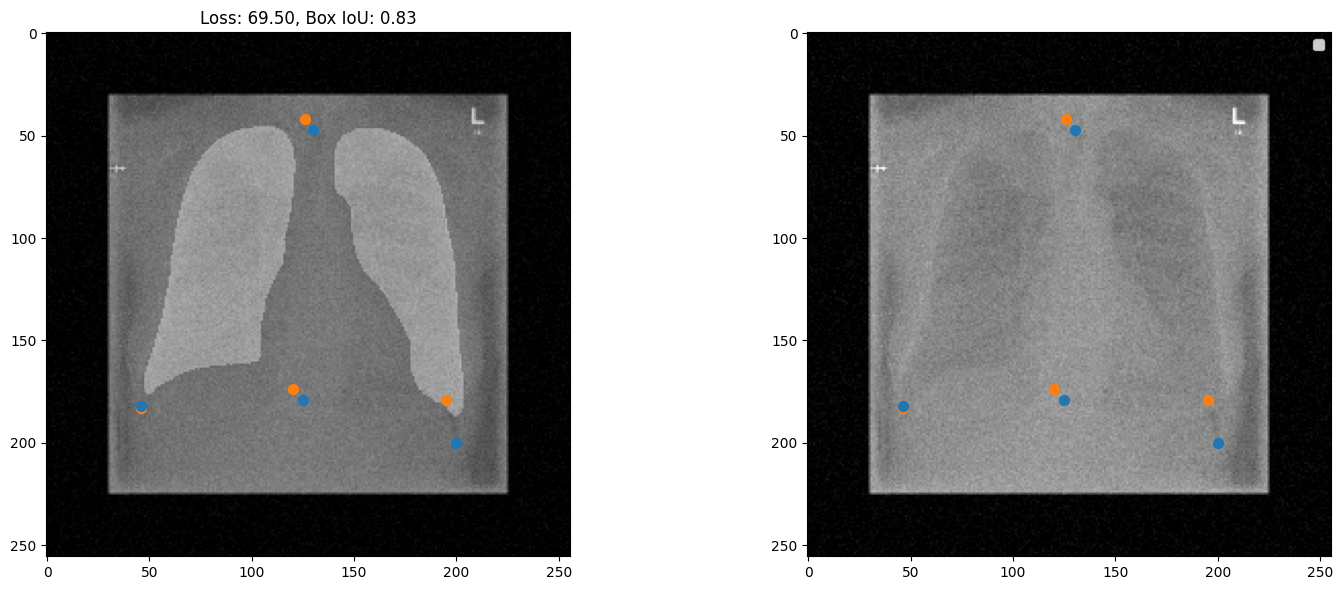

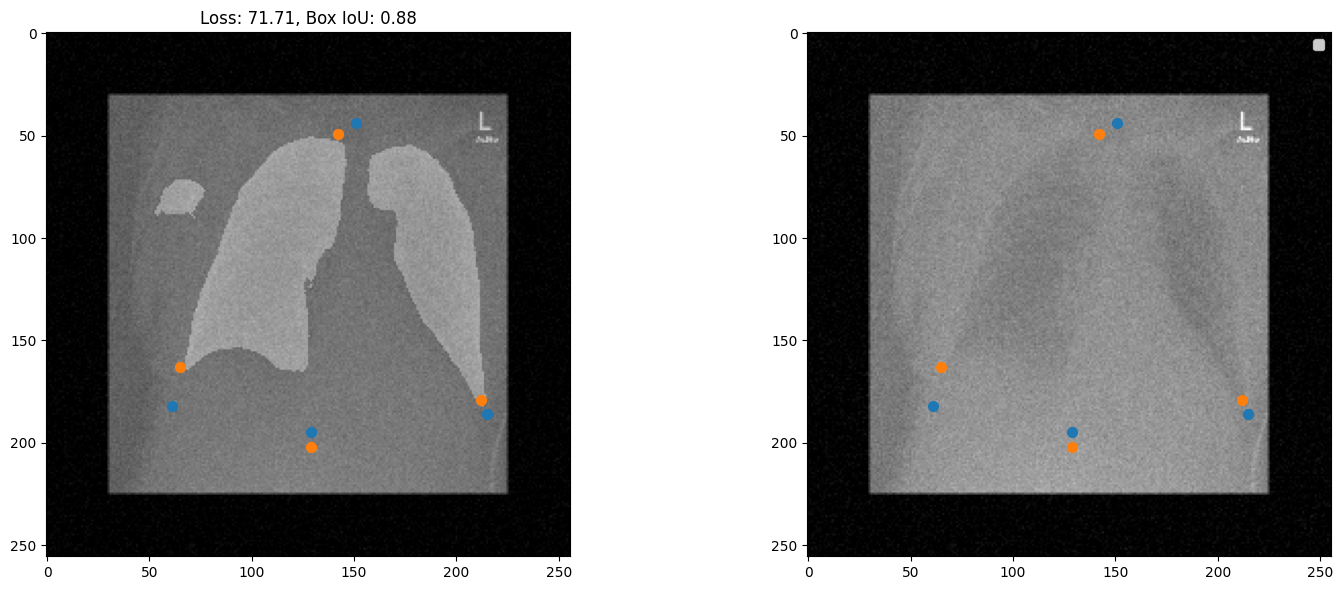

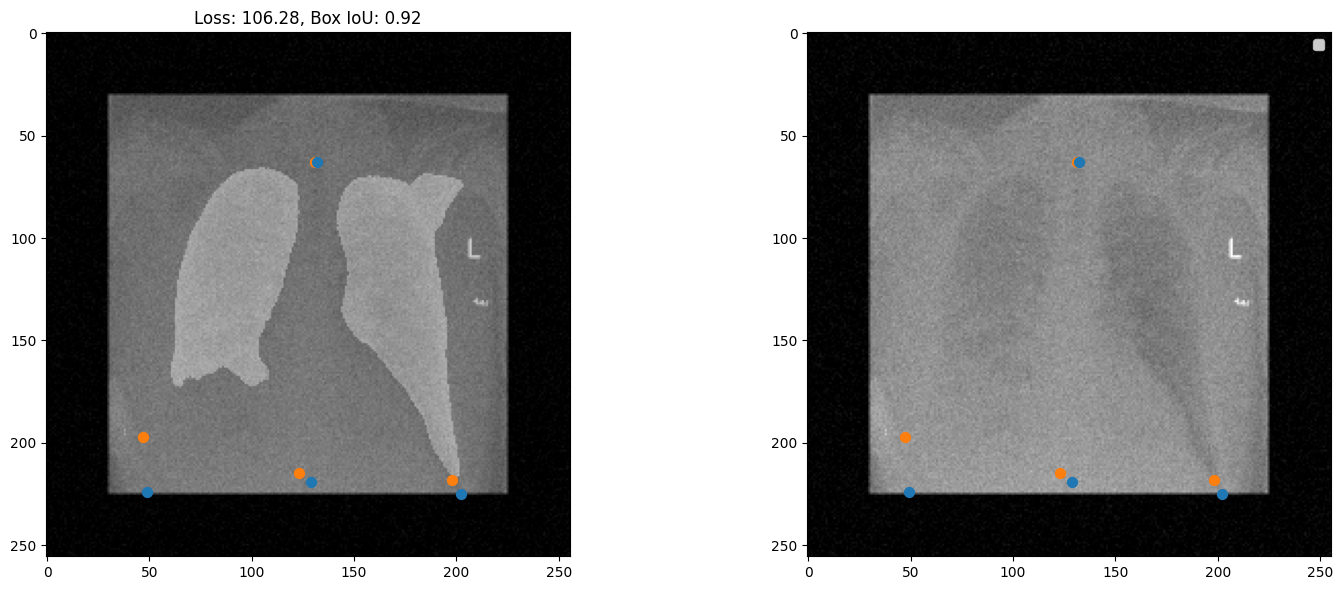

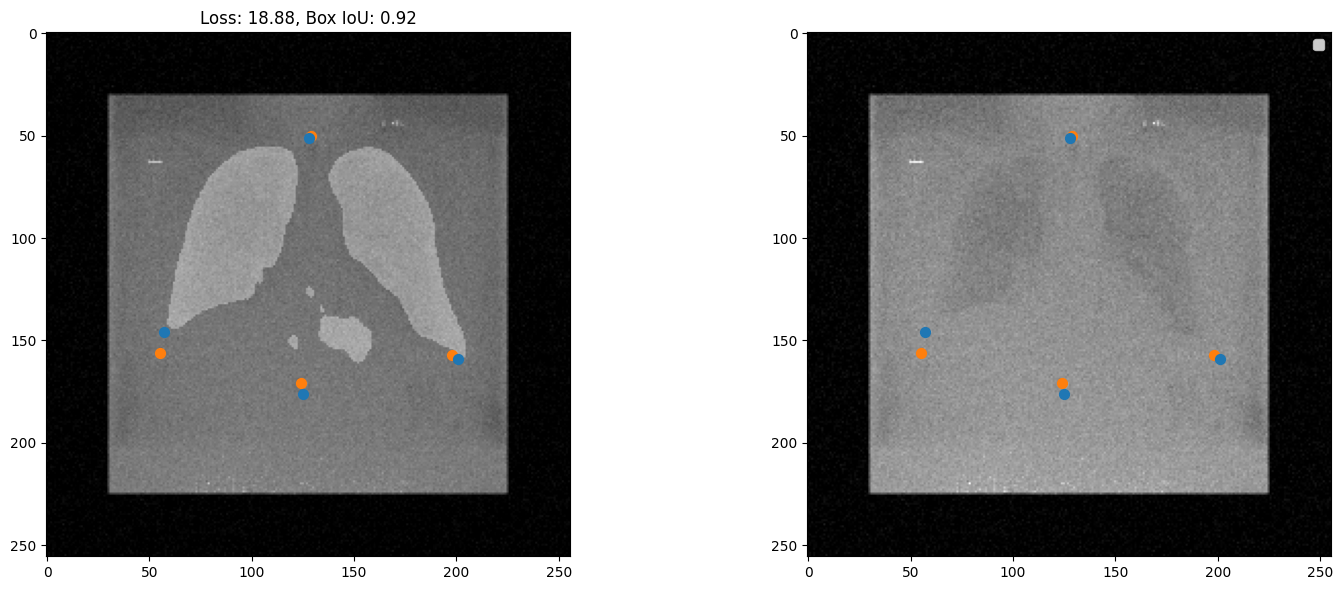

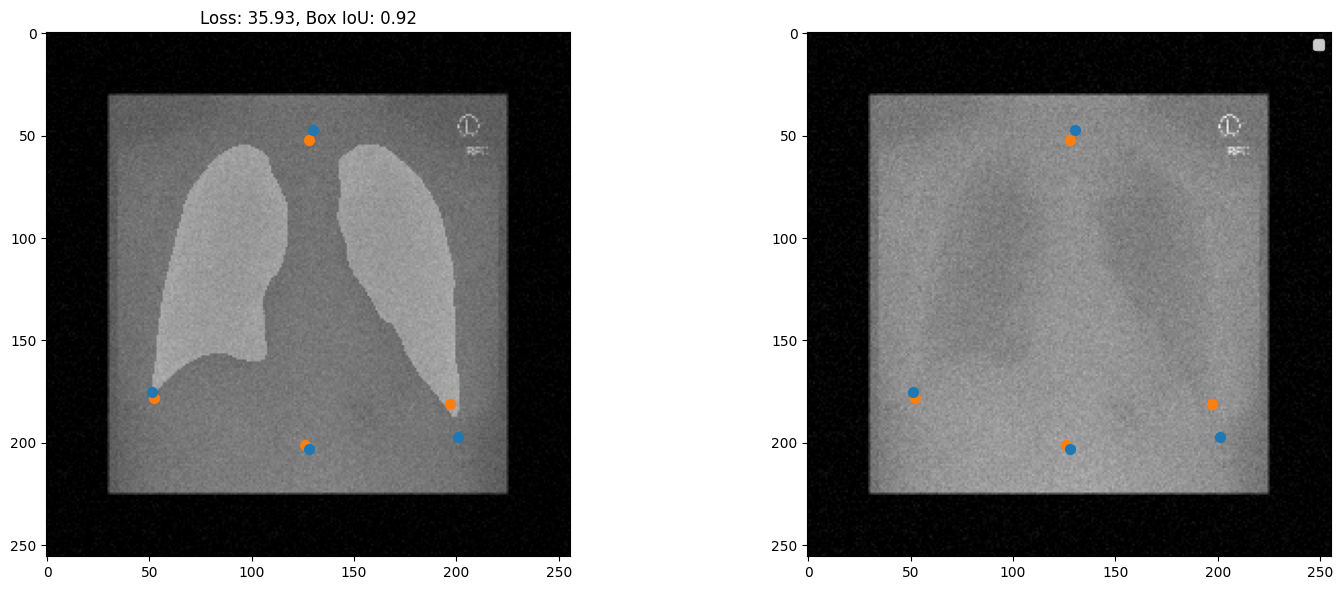

In [14]:
from fixpoint_utils import get_loader_keypoint
#train_loader, validation_loader, test_loader = get_loader_keypoint(BATCH_SIZE=1)
from Keypoint_dataset_gaussian import get_loader_keypoint_simulated
train_loader, validation_loader, test_loader = get_loader_keypoint_simulated(BATCH_SIZE=1)

load_checkpoint(EffNet, r'/home/alex/Documents/new try/Data/Studie_daten/safe_states/EffNet_Own_unet_gaussian_0.pth.tar')

i = 0
test_loader_iter = iter(test_loader)
for i in range(5):
    image, target_kp = next(test_loader_iter)
    show_image_keypoint_segmentation(image, target_kp, EffNet, Own_unet)

Test check

In [ ]:
model.eval()
loss = 0
IoU = 0
for image, targ in test_loader:
        img = image.to(device = DEVICE)
        target = targ.to(DEVICE)
        pred = model(img)
        loss += loss_func(pred, target.squeeze(1))
        IoU += keypoints_IoU_mult(image, targ.squeeze(1), pred)
        pred = pred[0].to('cpu').detach().numpy()
        plt.imshow(image[0][0], cmap='gray')
        for i in range(0, 8, 2):
                scatter1 = plt.scatter(pred[i], pred[i+1],color = 'C1')
                scatter2 = plt.scatter(targ[0,0,i], targ[0,0,i+1], color = 'C0')
        scatter1.set_label('predicted')
        scatter2.set_label('original')
        plt.legend()
        plt.show()
print('MSE:', loss.item()/len(test_loader))
print('Box IoU:', IoU.item()/len(test_loader.dataset))

Histogram of errors

In [ ]:
del loss, pred
torch.cuda.empty_cache()  

In [ ]:
model.eval()
loss = []
for image, targ in test_loader:
        for i in range(image.shape[0]):
            img = image[i].to(device = DEVICE).unsqueeze(0)
            target = targ[i].to(DEVICE)
            pred = model(img)
            loss.append(loss_func(pred, target.unsqueeze(0).squeeze(1)).item())
print(loss)
plt.hist(loss, bins = 50)

show example with highest loss

In [ ]:
indexes = [i for i, loss in enumerate(loss) if loss > 600]

subset = Subset(test_keypoint_ds, indexes)

subset_loader = DataLoader(subset,
                          batch_size= 1,
                          num_workers= NUM_WORKERS,
                          pin_memory= PIN_MEMORY,
                          shuffle= False)

In [ ]:
for image, kp in subset_loader:
    img = image.to(device = DEVICE)
    target = kp.to(DEVICE)
    pred = model(img)
    pred = pred[0].to('cpu').detach().numpy()
    plt.imshow(image[0][0], cmap='gray')
    for i in range(0, 8, 2):
        scatter1 = plt.scatter(pred[i], pred[i+1],color = 'C1')
        scatter2 = plt.scatter(kp[0,0,i], kp[0,0,i+1], color = 'C0')
    scatter1.set_label('predicted')
    scatter2.set_label('original')
    plt.legend()
    plt.show()

In [ ]:
from torch.utils.data import Subset

# Create a subset of the dataset using these indexes
subset = Subset(dataset, indexes)

# Create a DataLoader for this subset
subset_loader = DataLoader(subset, batch_size=1, shuffle=False)

In [ ]:
test_image_path = r'/home/alex/Documents/new try/Data/Studie_daten/Bilder_stehen/image_58.png' #r'/home/alex/Documents/new try/Lung Unet/data/test/images/CHNCXR_0002_0.png'


Test acc and max error examples